In [1]:
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
# data visualisation and manipulation
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import keras
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.engine.topology import Network
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image

import matplotlib.pyplot as plt
import scipy.misc

%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

Using TensorFlow backend.


In [2]:
import numpy as np
kernel = np.array([[-1/12, 2/12, -2/12, 2/12, -1/12], 
                   [2/12, -6/12, 8/12, -6/12, -2/12], 
                   [-2/12, 8/12, -12/12, 8/12, -2/12],
                   [2/12, -6/12, 8/12, -6/12, -2/12], 
                   [-1/12, 2/12, -2/12, 2/12, -1/12]])

In [3]:
kernel

array([[-0.08333333,  0.16666667, -0.16666667,  0.16666667, -0.08333333],
       [ 0.16666667, -0.5       ,  0.66666667, -0.5       , -0.16666667],
       [-0.16666667,  0.66666667, -1.        ,  0.66666667, -0.16666667],
       [ 0.16666667, -0.5       ,  0.66666667, -0.5       , -0.16666667],
       [-0.08333333,  0.16666667, -0.16666667,  0.16666667, -0.08333333]])

In [4]:
def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

In [5]:
train_a_dir='F:/Mine/MTECH DISSERTATION DOCUMENTS/DATASET COLLECTIONS/Dataset used in project/testing/train/cover'
train_b_dir='F:/Mine/MTECH DISSERTATION DOCUMENTS/DATASET COLLECTIONS/Dataset used in project/testing/train/stego'
test_a_dir='F:/Mine/MTECH DISSERTATION DOCUMENTS/DATASET COLLECTIONS/Dataset used in project/testing/test/cover'
test_b_dir='F:/Mine/MTECH DISSERTATION DOCUMENTS/DATASET COLLECTIONS/Dataset used in project/testing/test/stego'
valid_a_dir='F:/Mine/MTECH DISSERTATION DOCUMENTS/DATASET COLLECTIONS/Dataset used in project/testing/valid/cover'
valid_b_dir='F:/Mine/MTECH DISSERTATION DOCUMENTS/DATASET COLLECTIONS/Dataset used in project/testing/valid/stego'

In [6]:
def assign_label(img,img_class):
    return img_class

In [7]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [8]:
X = []
Z = []
X1 = []
Z1 = []
X2 = []
Z2 = []
def make_train_data(img_class,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,img_class)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        image = rgb2gray(img)
        img = convolve2D(image, kernel, padding=0) 
        #=img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))
def make_test_data(img_class,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,img_class)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        image = rgb2gray(img)
        img = convolve2D(image, kernel, padding=0)
        #img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X1.append(np.array(img))
        Z1.append(str(label))
def make_valid_data(img_class,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,img_class)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        image = rgb2gray(img)
        img = convolve2D(image, kernel, padding=0)
        #img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X2.append(np.array(img))
        Z2.append(str(label))

In [9]:
make_train_data('cover',train_a_dir)
make_train_data('stego',train_b_dir)
make_test_data('cover',test_a_dir)
make_test_data('stego',test_b_dir)
make_valid_data('cover',valid_a_dir)
make_valid_data('stego',valid_b_dir)

100%|██████████| 25/25 [00:00<00:00, 27.71it/s]


In [10]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
le=LabelEncoder()
Y=le.fit_transform(Z)
train_label = to_categorical(Y,2)
X=np.array(X)
train_img = X
Y1=le.fit_transform(Z1)
test_label = to_categorical(Y1,2)
X1=np.array(X1)
test_img = X1
Y2=le.fit_transform(Z2)
valid_label = to_categorical(Y2,2)
X2=np.array(X2)
valid_img = X2

In [11]:
train_img.shape

(200, 60, 60)

In [12]:
train_img = train_img.reshape(train_img.shape[0],train_img.shape[1],train_img.shape[2],1)

In [13]:
train_img.shape

(200, 60, 60, 1)

In [14]:
test_img.shape = (test_img.shape[0],test_img.shape[1],test_img.shape[2],1)

In [15]:
test_img.shape

(50, 60, 60, 1)

In [16]:
valid_img.shape

(50, 60, 60)

In [17]:
valid_img.shape = (valid_img.shape[0],valid_img.shape[1],valid_img.shape[2],1)

In [18]:
valid_img.shape

(50, 60, 60, 1)

In [19]:
def gaussian(x):
    mean = tf.math.reduce_mean(x)
    std = tf.math.reduce_std(x)
    return tf.exp(-((x-mean)**2)/(std)**2) 

In [20]:
model = Sequential()

In [21]:
#Second layer - Convolution and pooling
model.add(Conv2D(filters = 16, kernel_size = (5,5),strides=(1,1),padding = 'Valid',activation =gaussian, input_shape = (60,60,1)))
model.add(AveragePooling2D(pool_size=(3,3),strides=(2,2),padding = 'Same'))

In [22]:
#Third layer - Convolution and pooling
model.add(Conv2D(filters = 16, kernel_size = (3,3),strides=(1,1),padding = 'Valid',activation =gaussian))
model.add(AveragePooling2D(pool_size=(3,3),strides=(2,2),padding = 'Same'))

In [23]:
#Fourth layer - Convolution and pooling
model.add(Conv2D(filters = 16, kernel_size = (3,3),strides=(1,1),padding = 'Valid',activation =gaussian))
model.add(AveragePooling2D(pool_size=(3,3),strides=(2,2),padding = 'Same'))

In [24]:
#Fifth layer - Convolution and pooling
model.add(Conv2D(filters = 16, kernel_size = (5,5),strides=(1,1),padding = 'Valid',activation =gaussian))
model.add(AveragePooling2D(pool_size=(3,3),strides=(2,2),padding = 'Same'))

In [25]:
model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(2, activation = "softmax"))

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 56, 56, 16)        416       
_________________________________________________________________
average_pooling2d_1 (Average (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 16)        2320      
_________________________________________________________________
average_pooling2d_2 (Average (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 16)        2320      
_________________________________________________________________
average_pooling2d_3 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 16)         

In [27]:
train_img.shape

(200, 60, 60, 1)

In [28]:
batch_size=128
epochs=30

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [29]:
#Data Augmentation to prevent Overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_img)

In [30]:
#Compiling the Keras Model & Summary
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [31]:
train_model = model.fit_generator(datagen.flow(train_img,train_label, batch_size=batch_size),
                              epochs = epochs, validation_data = (valid_img,valid_label),
                              verbose = 1, steps_per_epoch=train_img.shape[0] // batch_size)

Epoch 1/30
1/1 [==============================] - 4s 4s/step - loss: 0.7713 - accuracy: 0.4609 - val_loss: 0.6956 - val_accuracy: 0.5000
Epoch 2/30
1/1 [==============================] - 0s 496ms/step - loss: 0.7063 - accuracy: 0.4306 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 3/30
1/1 [==============================] - 1s 752ms/step - loss: 0.6896 - accuracy: 0.5391 - val_loss: 0.6969 - val_accuracy: 0.5000
Epoch 4/30
1/1 [==============================] - 0s 403ms/step - loss: 0.7180 - accuracy: 0.4306 - val_loss: 0.6901 - val_accuracy: 0.5000
Epoch 5/30
1/1 [==============================] - 0s 408ms/step - loss: 0.6863 - accuracy: 0.5556 - val_loss: 0.6885 - val_accuracy: 0.5000
Epoch 6/30
1/1 [==============================] - 0s 493ms/step - loss: 0.6948 - accuracy: 0.4688 - val_loss: 0.6887 - val_accuracy: 0.7000
Epoch 7/30
1/1 [==============================] - 0s 313ms/step - loss: 0.6894 - accuracy: 0.6528 - val_loss: 0.6887 - val_accuracy: 0.4600
Epoch 8/30
1/1 [=======

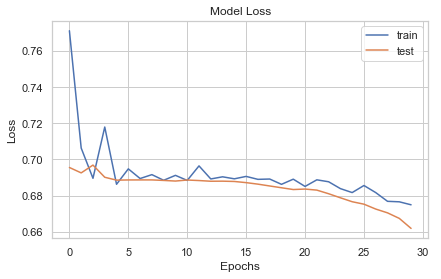

In [32]:
#Evaluating the Model Performance
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

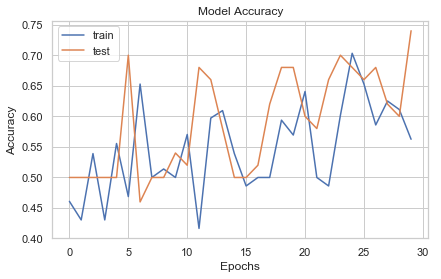

In [33]:
plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [34]:
test_loss, test_acc = model.evaluate(test_img, test_label)

50/50 [==============================] - ETA:  - 0s 2ms/step


In [35]:
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.6837347412109375
Test accuracy: 0.5199999809265137


In [77]:
# getting predictions on val set.
pred=model.predict(test_img)
pred_digits=np.argmax(pred,axis=1)

In [107]:
#To test for the given single input
im1=cv2.imread('container349.jpg')
image = rgb2gray(im1)
img = convolve2D(image, kernel, padding=0)
img = img.reshape(1,60,60,1)
pred=model.predict(img)
pred_digits=np.argmax(pred,axis=1)

E:\App\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


"[['cover']]"

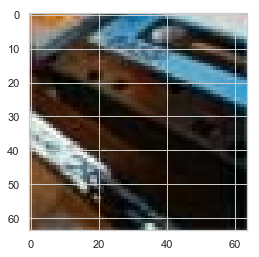

In [108]:
fig1,ax1=plt.subplots(1,1)
ax1.imshow(im1)
str(le.inverse_transform([pred_digits]))